# Analysis of eight-probe Neuropixels recordings of spontaneous neural activity in mice (w19-20)
---
### Tasks
- Plot neural spike train reordered/clustered
- Plot average spikes over time
- Validate 3D coordinates of neurons

In [1]:
using Plots, Measures; gr()
using MAT, Printf
using LinearAlgebra, Statistics, Random
using Clustering, Distances
using InformationMeasures
using Ripserer
using BenchmarkTools

In [2]:
# Load all data in a three-element array of dictionaries
# Each element corresponding to each mouse maps variable names to their contents  
mice_names = ["Krebs", "Waksman", "Robbins"]
data = [MAT.matread("../../Data/source/$(mice_names[i])withFaces_KS2.mat") for i in 1:3];

LoadError: File "../Data/source/KrebswithFaces_KS2.mat" does not exist and create was not specified

### Coordinates Validation

In [53]:
function diff(v)
    rep_mat = repeat(v, 1, length(v))
    diff_mat = abs.(rep_mat - transpose(rep_mat))
    
    return diff_mat
end

function coordValid(data, id)
    probeIDs = data[id]["iprobe"]       # probe IDs of neurons
    hop = data[id]["Wh"]                # neuron heights on probes
    coord = data[id]["ccfCoords"]       # neuron 3D coordinates
    
    plot_holder = Array{Plots.Plot{Plots.GRBackend}}(undef, 8*2)
    
    for i=1:8
        extract_idx = vec(probeIDs .== i)
        D_hop = diff(hop[extract_idx])
        D_coord = Distances.pairwise(Distances.Euclidean(), coord[extract_idx, :], dims=1)
        
        plot_holder[i*2-1] = heatmap(D_hop, title="M$id-P$i-hop")
        plot_holder[i*2] = heatmap(D_coord, title="M$id-P$i-coord")
        #println(mean(abs.(D_hop - D_coord)))
    end
    
    display(plot(plot_holder[1:8]..., layout=(4, 2), size=(1200, 1800), yflip=true))
    display(plot(plot_holder[9:16]..., layout=(4, 2), size=(1200, 1800), yflip=true))
end

coordValid (generic function with 1 method)

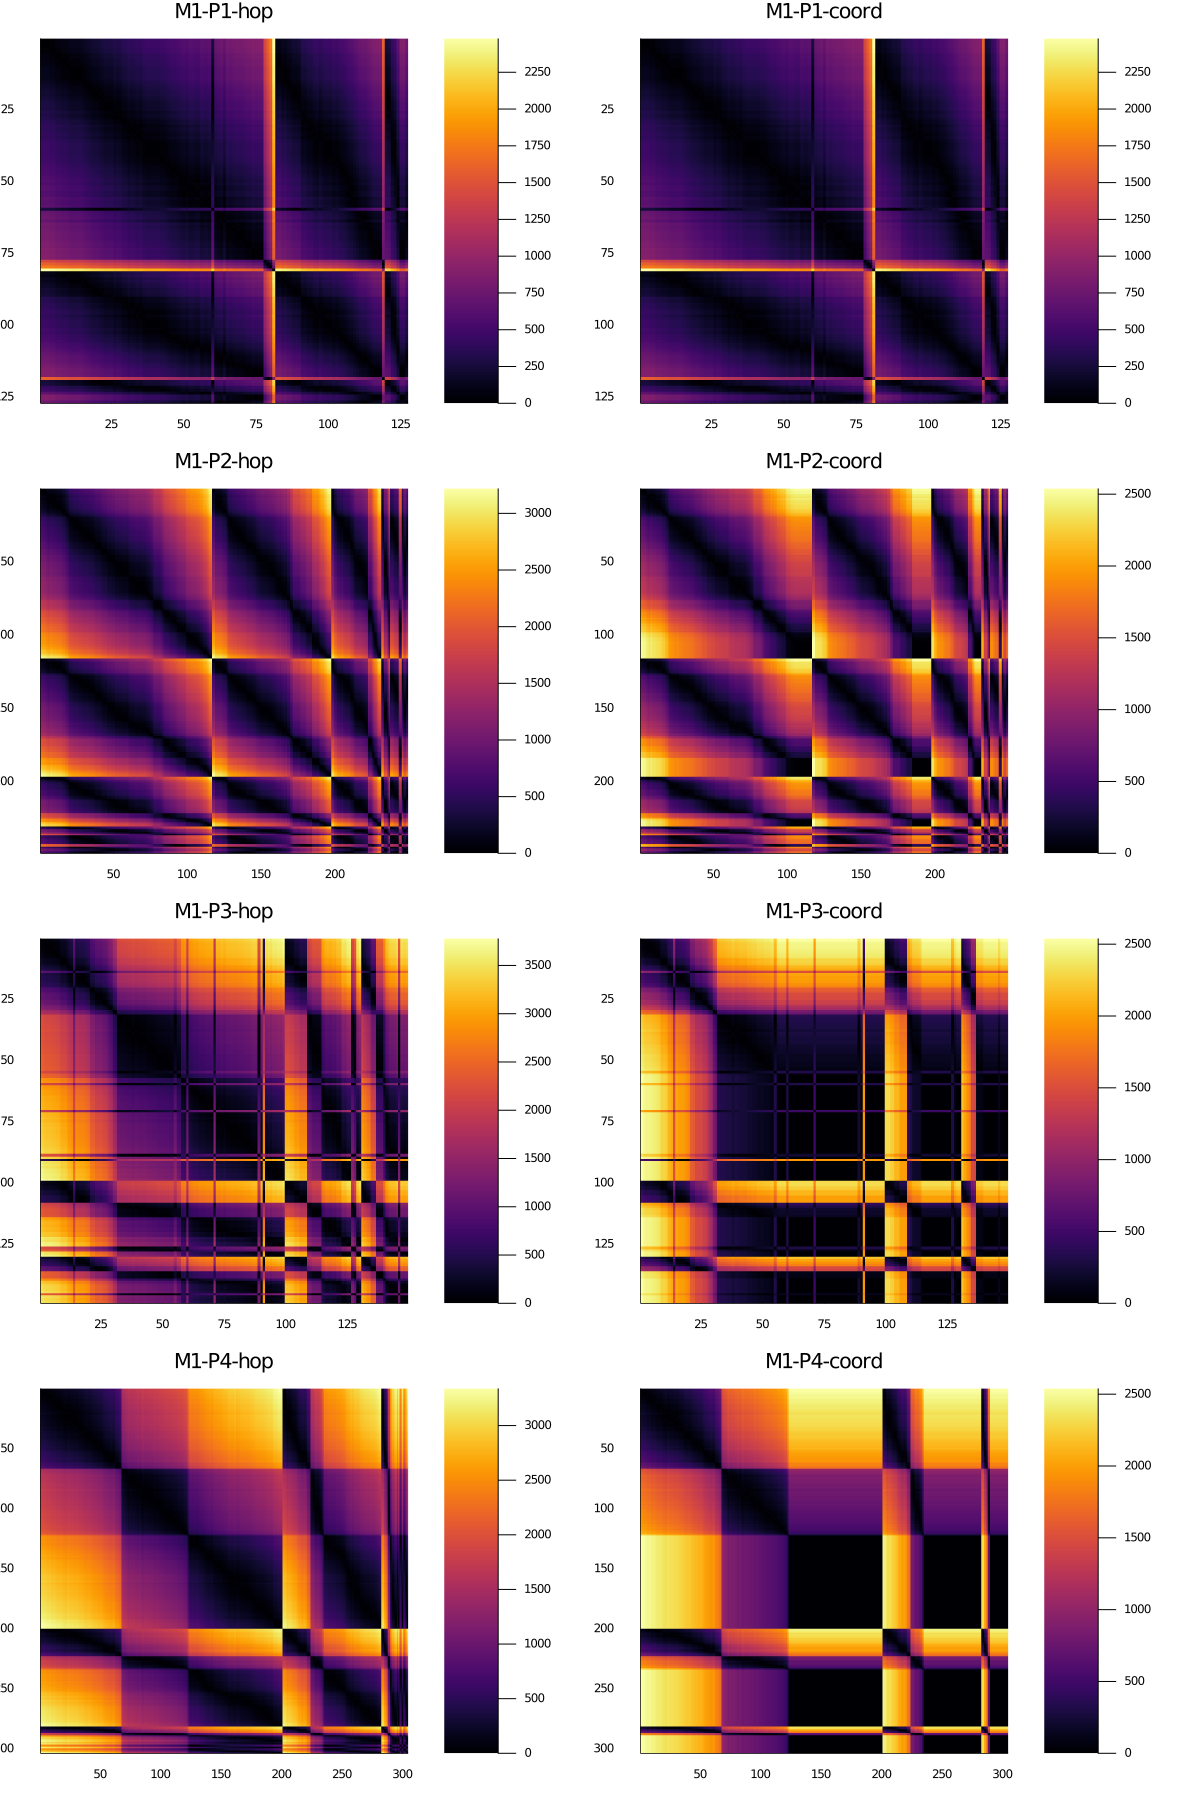

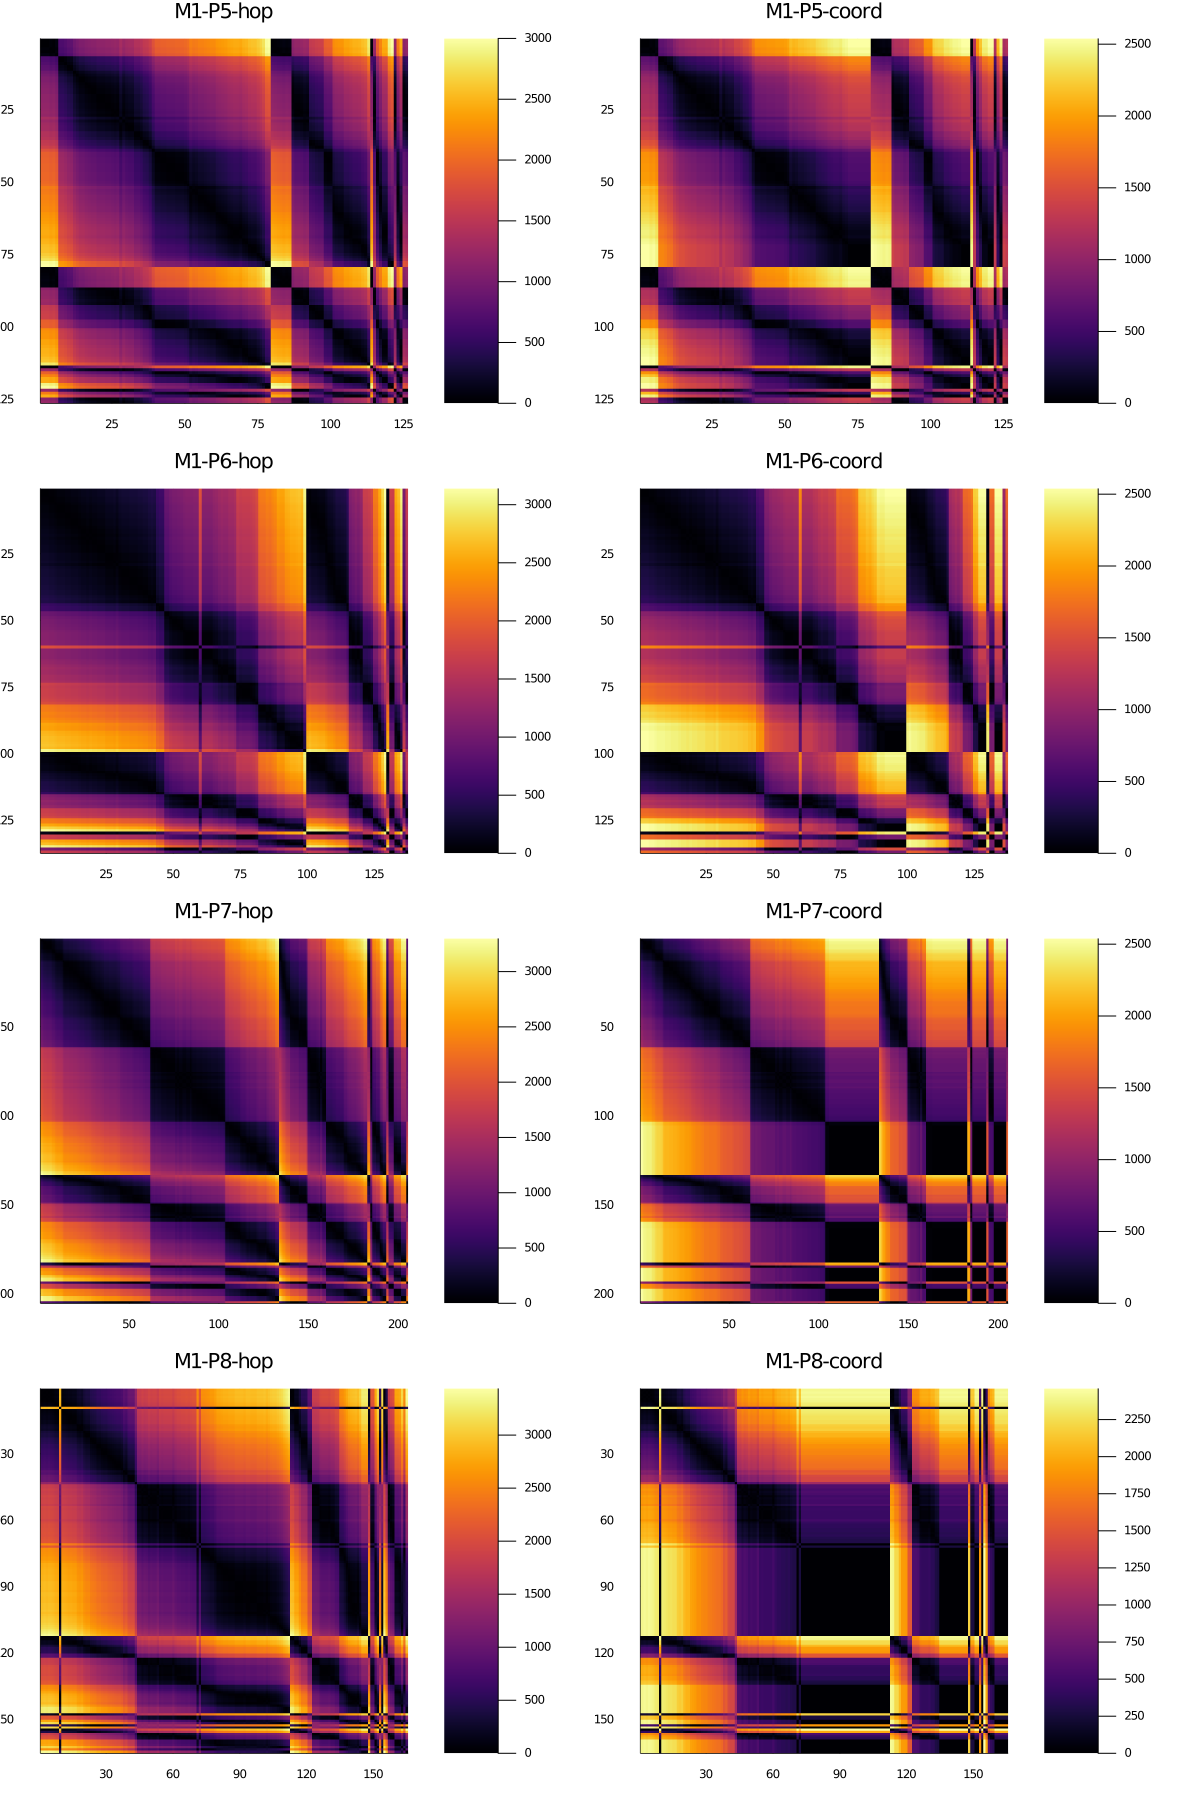

In [54]:
coordValid(data, 1)

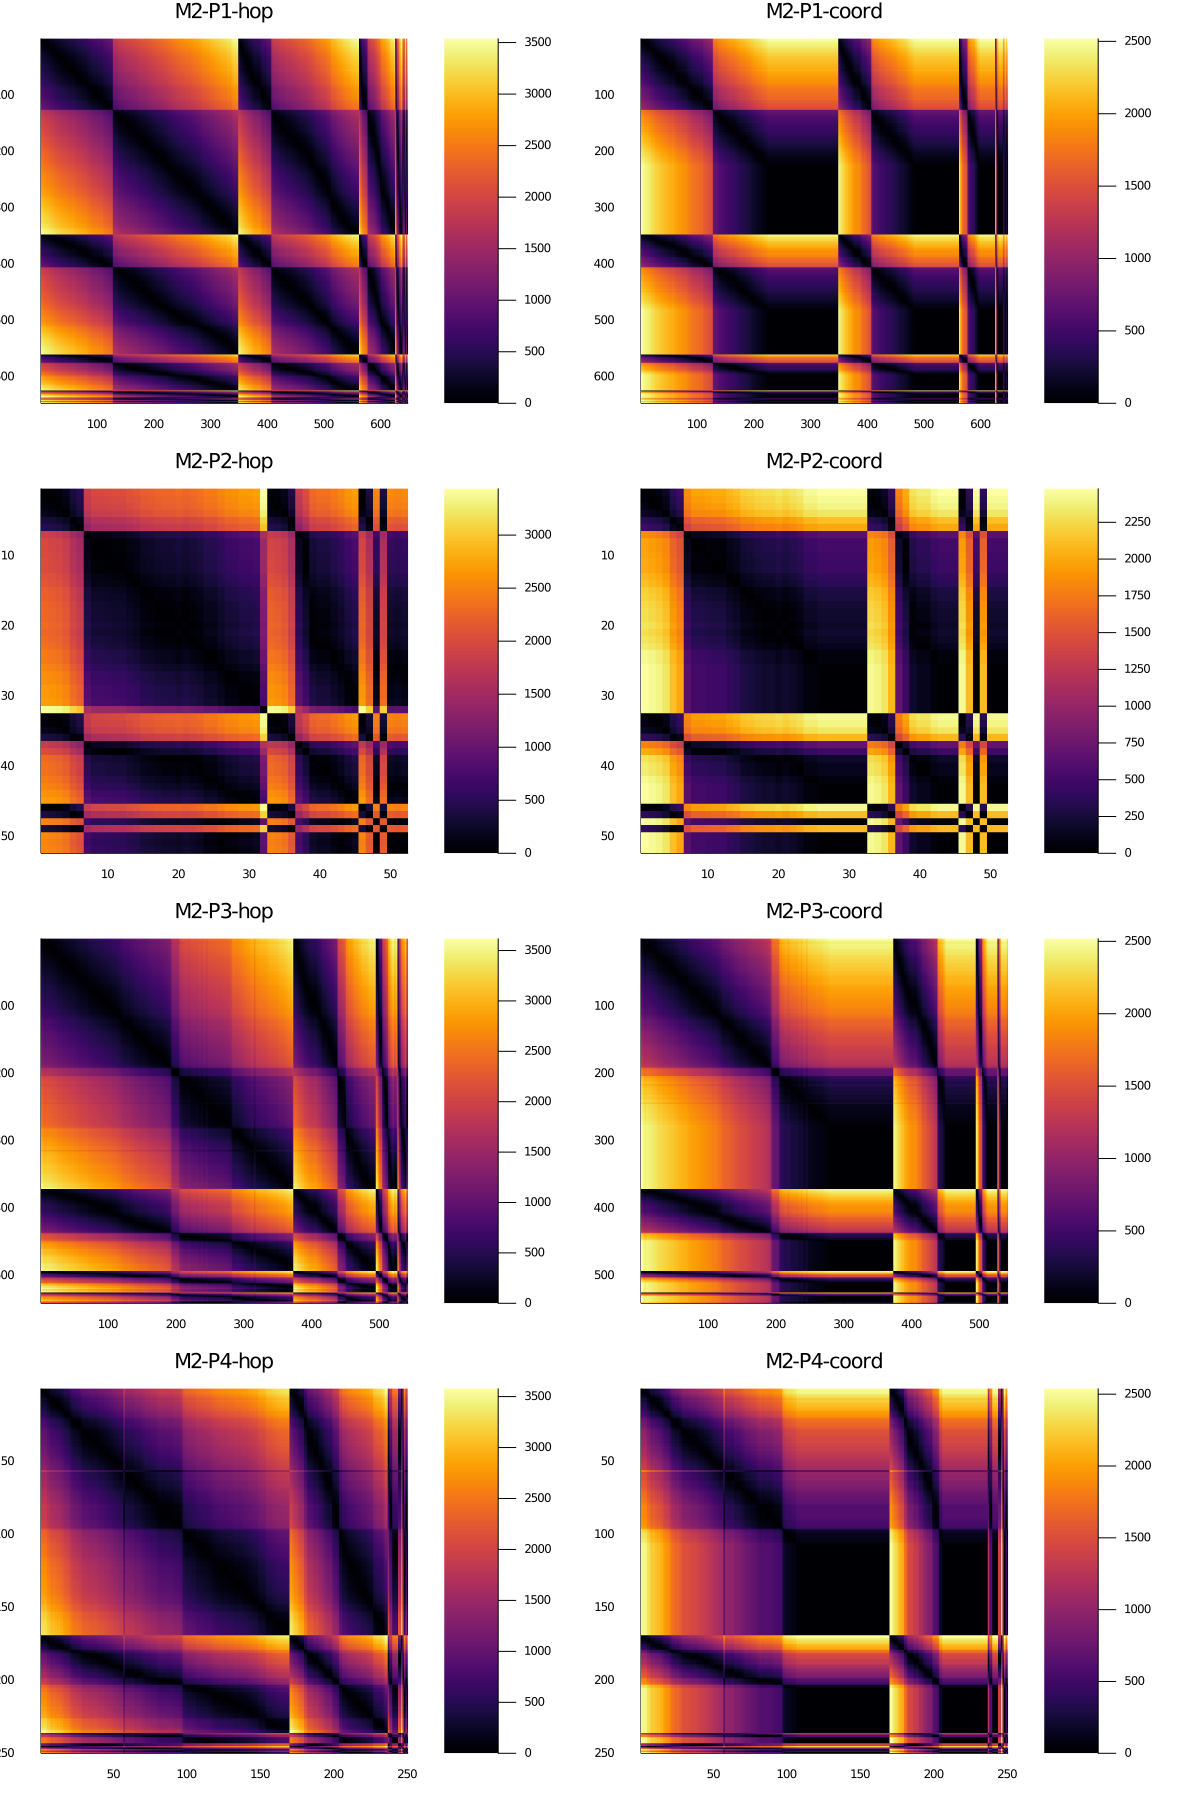

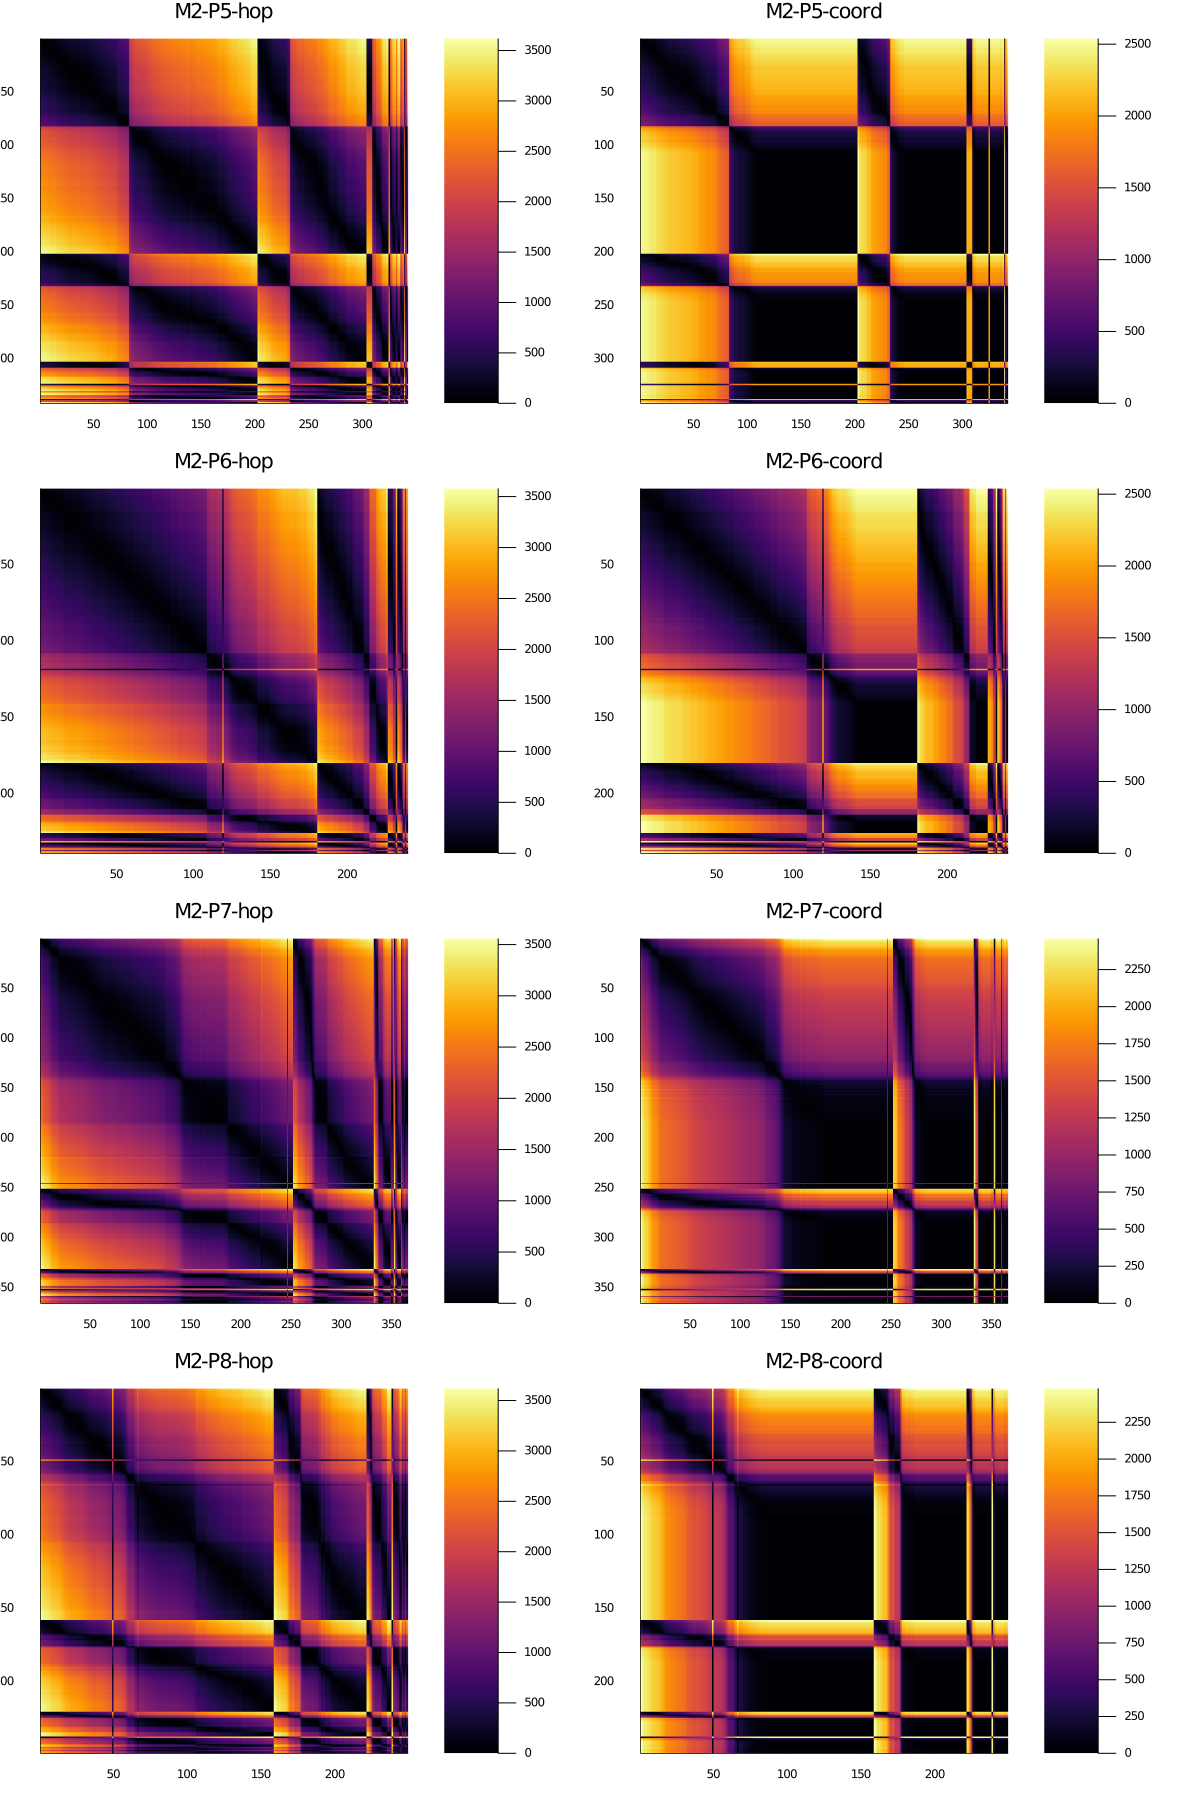

In [55]:
coordValid(data, 2)

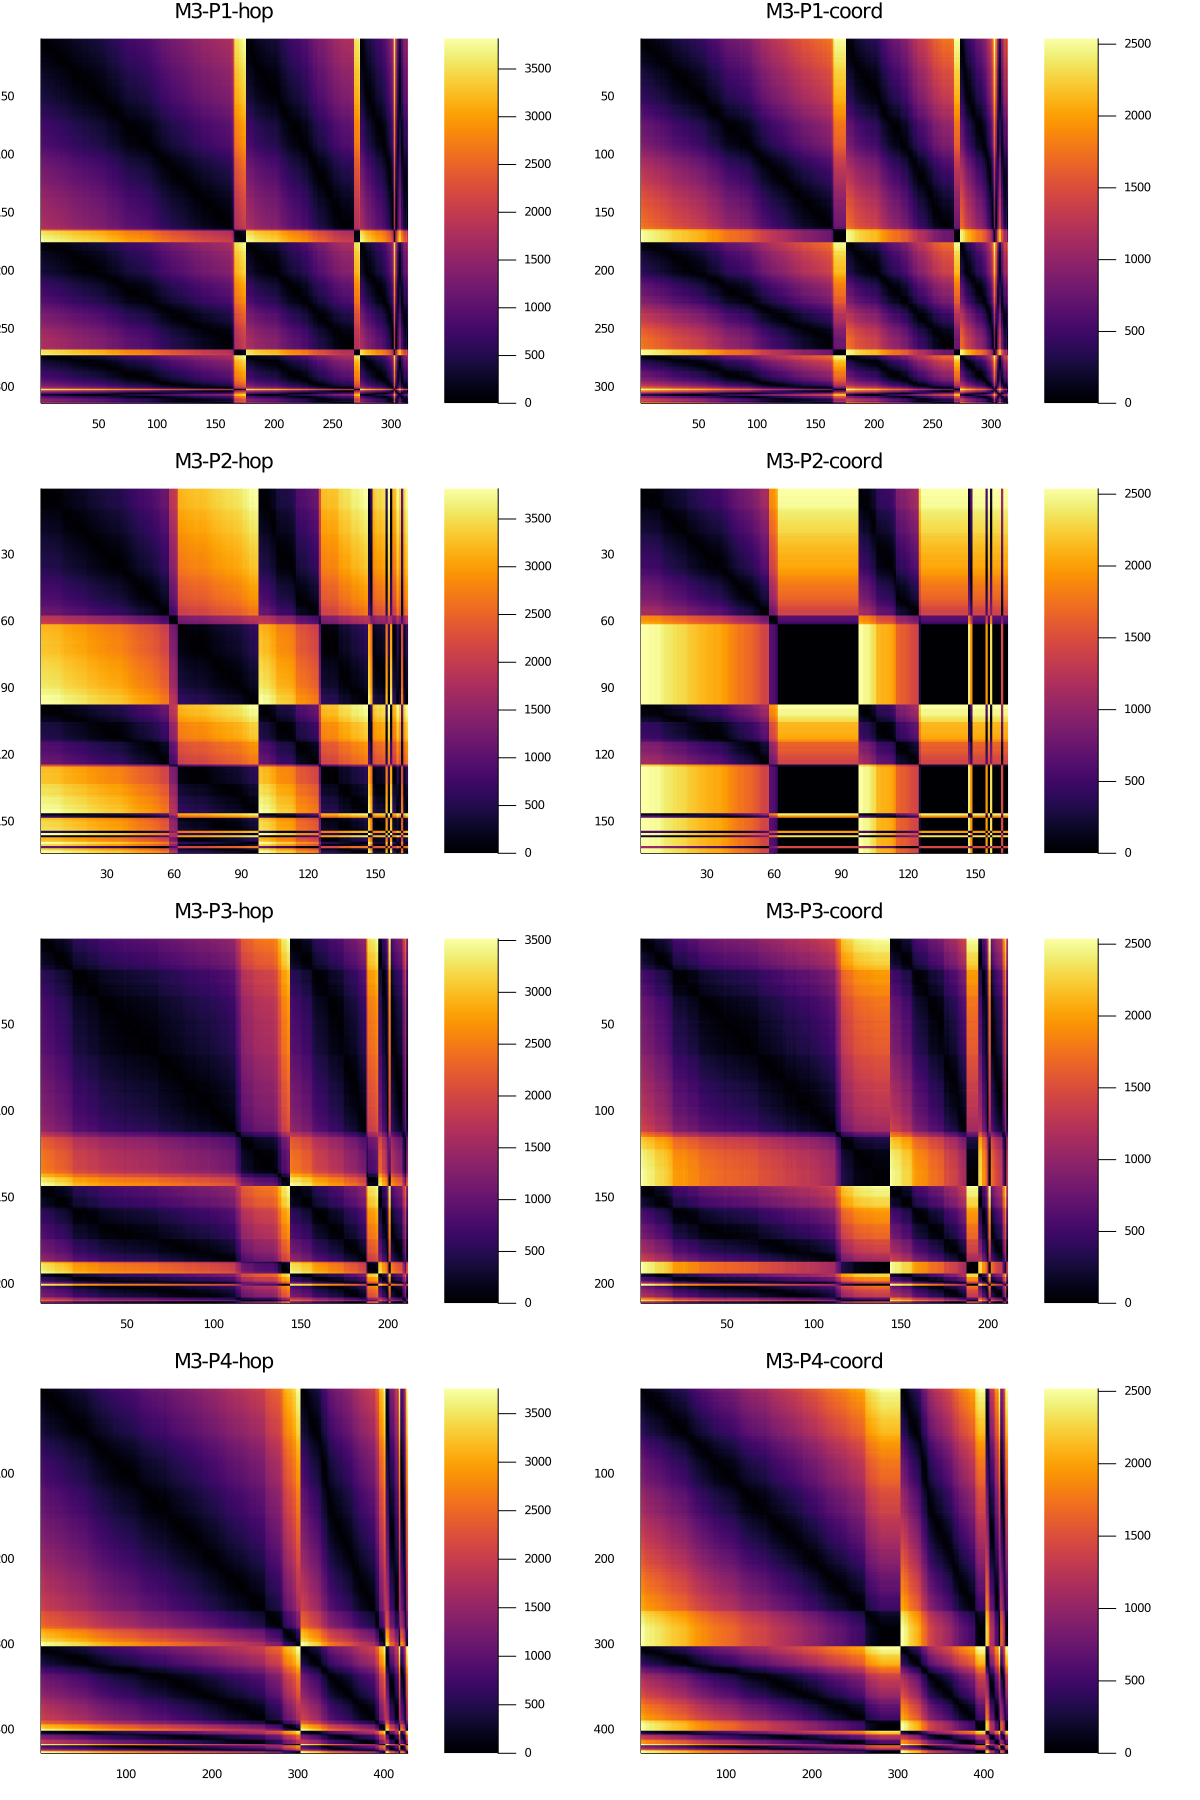

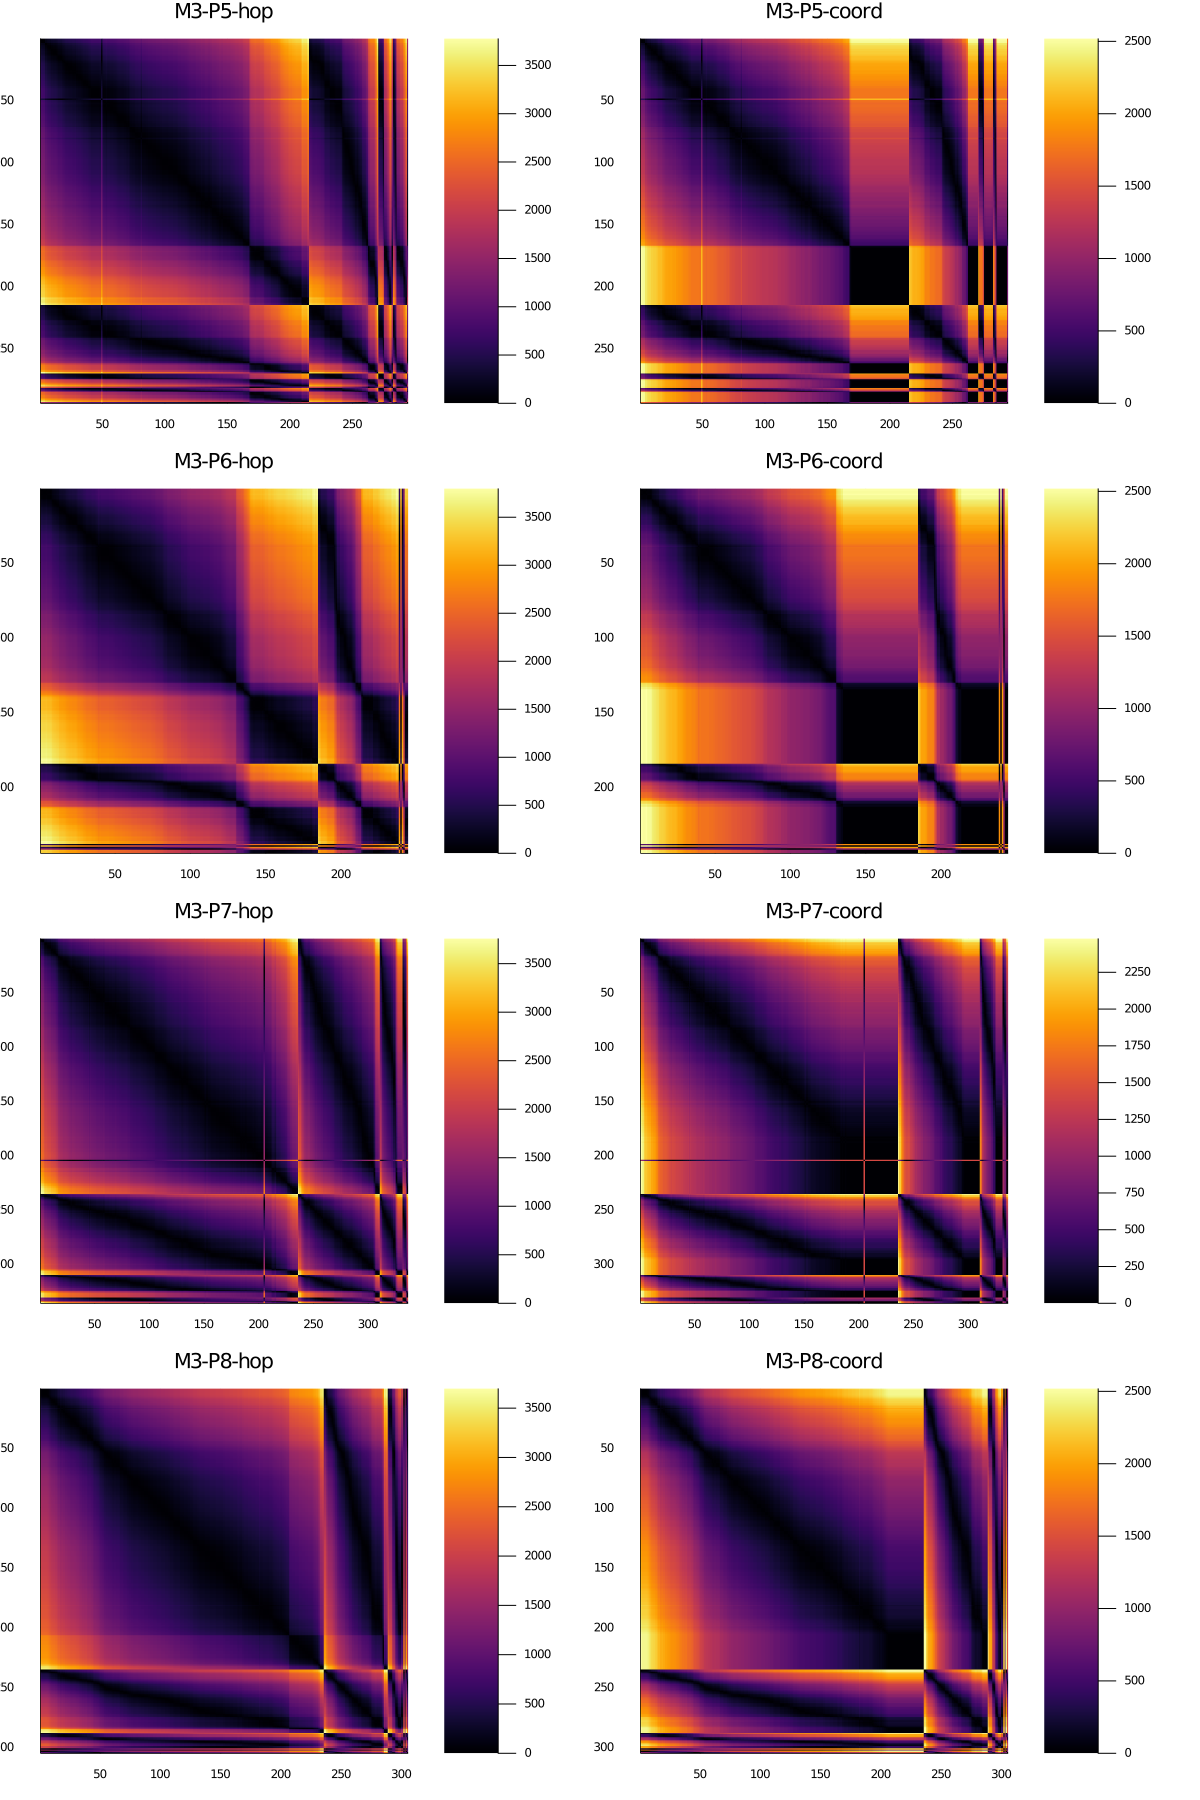

In [56]:
coordValid(data, 3)

### Spike Train Visiualization (cont.)

In [3]:
function spktrainDisp(data, id, plot_type; clust=false, binary=false)
    spktrain = data[id]["stall"]
    regIDs = data[id]["brainLoc"]
    reglbs = data[id]["areaLabels"]
    
    cap = binary ? 1 : 36      # 36 is the highest number of spikes for a single sample and single neuron
    N, T = size(spktrain)      # N : number of neurons, T : number of samples (sampling rate x recording time)

    unique_regIDs = convert(Array{Int64, 1}, sort(unique(regIDs)))
    unique_regIDs = unique_regIDs[1] == 0 ? unique_regIDs[2:end] : unique_regIDs
    n_reg = length(unique_regIDs)
    plot_holder = Array{Plots.Plot{Plots.GRBackend}}(undef, n_reg)
    plot_heights = Array{Float64, 1}(undef, n_reg)

    if plot_type == :average
        println("Number of neurons|Range of average number of spikes")
    end
    
    for i=1:n_reg
        filter = vec(regIDs .== unique_regIDs[i])
        n_neuron_reg = sum(filter)
        if plot_type == :heatmap
            plot_heights[i] = round(n_neuron_reg/N; digits=3)
            spktrain_reg = spktrain[filter, :]
            if clust
                C = Statistics.cor(spktrain_reg, dims=2)
                D = Distances.pairwise(Distances.CosineDist(), C, dims=1)
                res = Clustering.hclust(D, linkage=:average)
                sort_idx = res.order
            else
                sort_idx = 1:n_neuron_reg
            end 
            plot_holder[i] = heatmap(spktrain_reg[sort_idx, :], title=reglbs[unique_regIDs[i]], clims=(0, cap),
                             color=cgrad(:grays, rev=true), colorbar=false, axis=false, ticks=false)
        elseif plot_type == :average
            plot_heights[i] = round(1/n_reg; digits=3)
            avg_spks = mean(spktrain[filter, :], dims=1)
            plot_holder[i] = plot(transpose(avg_spks), title=reglbs[unique_regIDs[i]],
                                  ylim=(0,3), ticks=false, grid=false, legend=false, widen=false)
            println(reglbs[unique_regIDs[i]] * ": $(sum(filter))|[$(round(minimum(avg_spks); digits=4)), $(round(maximum(avg_spks); digits=4))]")
        end
    end
    
    plot(plot_holder..., titleposition=:left, titlefontsize=20,
         layout=grid(n_reg, 1, heights=plot_heights), size=(round(T/10), N))

    savefig("../Plots/spktrain_$(plot_type)_M$(id).png")
end

spktrainDisp (generic function with 1 method)

In [4]:
spktrainDisp(data, 1, :heatmap, clust=true, binary=true)

In [5]:
spktrainDisp(data, 2, :heatmap, clust=true, binary=true)

In [7]:
spktrainDisp(data, 3, :heatmap, clust=true, binary=true)